# CDA Homework 3

# PART 1: Implementation of Expectation-Maximization Algorithm for Gaussian Mixture Modeling on MNIST Dataset

## Part 1 Question 1

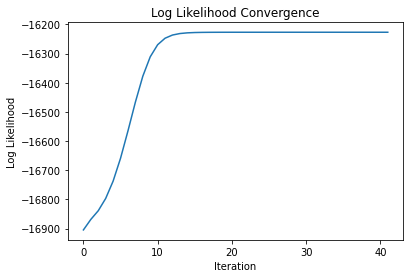

In [9]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(100)

# Load data
data_path = 'data.mat'
label_path = 'label.mat'
data = sio.loadmat(data_path)['data']
labels = sio.loadmat(label_path)['trueLabel'].squeeze()

# Filter data for digits '2' and '6'
filter_indices = (labels == 2) | (labels == 6)
filtered_images = data[:, filter_indices]
filtered_labels = labels[filter_indices]

# PCA to reduce to 4 dimensions
pca = PCA(n_components=4)
reduced_data = pca.fit_transform(filtered_images.T)

# Initialize GMM parameters
num_components = 2
n_dimensions = 4
means = np.random.randn(num_components, n_dimensions)
covariances = [np.dot(S, S.T) + np.eye(n_dimensions) for S in np.random.randn(num_components, n_dimensions, n_dimensions)]
weights = np.full(num_components, 1 / num_components)

# Function to compute log-likelihood
def log_likelihood(data, means, covariances, weights):
    ll = sum(weights[i] * multivariate_normal.pdf(data, mean=means[i], cov=covariances[i]) for i in range(num_components))
    return np.sum(np.log(ll))

# EM algorithm
max_iter = 100
tolerance = 1e-6
log_likelihood_history = []
for iteration in range(max_iter):
    # E-step
    responsibilities = np.array([weights[k] * multivariate_normal.pdf(reduced_data, mean=means[k], cov=covariances[k]) for k in range(num_components)]).T
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    # M-step
    Nk = responsibilities.sum(axis=0)
    for k in range(num_components):
        means[k] = np.dot(responsibilities[:, k], reduced_data) / Nk[k]
        diff = reduced_data - means[k]
        covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k] + np.eye(n_dimensions)
        weights[k] = Nk[k] / np.sum(Nk)

    # Check convergence
    current_log_likelihood = log_likelihood(reduced_data, means, covariances, weights)
    log_likelihood_history.append(current_log_likelihood)
    if iteration > 0 and np.abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tolerance:
        break

# Plot log-likelihood
plt.plot(log_likelihood_history)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood Convergence')
plt.show()


## Part 1 Question 2

Numerical weights for each component: [0.51010047 0.48989953]


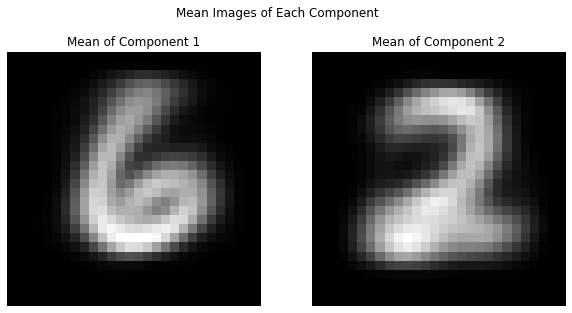

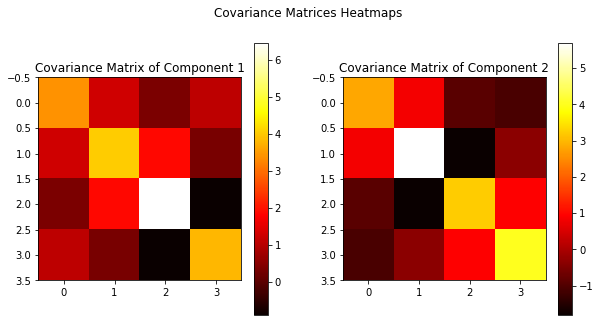

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# Step 1: Print the numerical weights for each component
print("Numerical weights for each component:", weights)

# Step 2: Project the mean vectors back to the original space and visualize as images
original_space_means = pca.inverse_transform(means)  # Project back to original space using PCA components

# Reshape and plot each mean vector as a 28x28 image, ensuring correct orientation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, mean in enumerate(original_space_means):
    mean_image = mean.reshape(28, 28)  # Reshape to 28x28 image
    mean_image = np.fliplr(mean_image)  # Flip image horizontally
    mean_image = np.rot90(mean_image) # clockwise rotation 90 degrees
    axes[i].imshow(mean_image, cmap='gray')
    axes[i].set_title(f'Mean of Component {i+1}')
    axes[i].axis('off')
plt.suptitle('Mean Images of Each Component')
plt.show()

# Step 3: Visualize the covariance matrices as heatmap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, covariance in enumerate(covariances):
    im = axes[i].imshow(covariance, cmap='hot', interpolation='nearest')
    axes[i].set_title(f'Covariance Matrix of Component {i+1}')
    plt.colorbar(im, ax=axes[i])
plt.suptitle('Covariance Matrices Heatmaps')
plt.show()


## Part 1 Question 3

In [11]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Load data
data_path = 'data.mat'
label_path = 'label.mat'
data = sio.loadmat(data_path)['data']
labels = sio.loadmat(label_path)['trueLabel'].squeeze()

# Filter data for digits '2' and '6'
filter_indices = (labels == 2) | (labels == 6)
filtered_images = data[:, filter_indices]
filtered_labels = labels[filter_indices]

# PCA to reduce to 4 dimensions
pca = PCA(n_components=4)
reduced_data = pca.fit_transform(filtered_images.T)

# Assuming 'means', 'covariances', 'weights' are from the previously fitted GMM model

# Calculate responsibilities for GMM
responsibilities = np.array([weights[k] * multivariate_normal.pdf(reduced_data, mean=means[k], cov=covariances[k]) for k in range(len(weights))]).T
gmm_labels = responsibilities.argmax(axis=1)

# Convert GMM cluster labels to match the original labels '2' and '6'
gmm_labels_mapped = np.where(gmm_labels == gmm_labels[filtered_labels == 2][0], 2, 6)

# Calculate misclassification rate for GMM
gmm_accuracy = accuracy_score(filtered_labels, gmm_labels_mapped)
gmm_misclassification_rate = 1 - gmm_accuracy

print(f"GMM Misclassification Rate: {gmm_misclassification_rate:.4f}")

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(reduced_data)
kmeans_labels = kmeans.labels_

# Convert K-means cluster labels to match the original labels '2' and '6'
kmeans_labels_mapped = np.where(kmeans_labels == kmeans_labels[filtered_labels == 2][0], 2, 6)

# Calculate misclassification rate for K-means
kmeans_accuracy = accuracy_score(filtered_labels, kmeans_labels_mapped)
kmeans_misclassification_rate = 1 - kmeans_accuracy

print(f"K-means Misclassification Rate: {kmeans_misclassification_rate:.4f}")

# Compare performances
if gmm_misclassification_rate < kmeans_misclassification_rate:
    print("GMM achieves better performance.")
else:
    print("K-means achieves better performance.")


GMM Misclassification Rate: 0.0362
K-means Misclassification Rate: 0.0698
GMM achieves better performance.


---

# PART 3: Bayes Classifier for spam filtering

## Part 3 Question 1

In [12]:
# Vocabulary and messages
vocabulary = ["secret", "offer", "low", "price", "valued", "customer", "today", "dollar", "million", "sports", "is", "for", "play", "healthy", "pizza"]
spam_messages = ["million dollar offer for today", "secret offer today", "secret is secret"]
non_spam_messages = ["low price for valued customer today", "play secret sports today", "sports is healthy", "low price pizza today"]

# Calculate class priors
P_y0 = len(spam_messages) / (len(spam_messages) + len(non_spam_messages))
P_y1 = len(non_spam_messages) / (len(spam_messages) + len(non_spam_messages))

print(f"P(y = 0) (Spam): {P_y0}")
print(f"P(y = 1) (Non-Spam): {P_y1}")

# Function to create feature vector
def create_feature_vector(message, vocabulary):
    words = message.split()
    return [words.count(word) for word in vocabulary]

# Create feature vectors for spam and non-spam messages
spam_feature_vectors = [create_feature_vector(msg, vocabulary) for msg in spam_messages]
non_spam_feature_vectors = [create_feature_vector(msg, vocabulary) for msg in non_spam_messages]

# Display feature vectors
print("\nSpam Feature Vectors:")
for vector in spam_feature_vectors:
    print(vector)

print("\nNon-Spam Feature Vectors:")
for vector in non_spam_feature_vectors:
    print(vector)


P(y = 0) (Spam): 0.42857142857142855
P(y = 1) (Non-Spam): 0.5714285714285714

Spam Feature Vectors:
[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

Non-Spam Feature Vectors:
[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


## Part 3 Question 2

In [13]:
import numpy as np

# Feature vectors for each message (as previously defined)
spam_feature_vectors = [
    [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
]

non_spam_feature_vectors = [
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
]

# Combine vectors into numpy arrays
spam_vectors = np.array(spam_feature_vectors)
non_spam_vectors = np.array(non_spam_feature_vectors)

# Calculate sums for theta
spam_word_sums = np.sum(spam_vectors, axis=0)
non_spam_word_sums = np.sum(non_spam_vectors, axis=0)

# Calculate total counts
total_spam_words = np.sum(spam_word_sums)
total_non_spam_words = np.sum(non_spam_word_sums)

# Calculate theta values
theta_spam = spam_word_sums / total_spam_words
theta_non_spam = non_spam_word_sums / total_non_spam_words

print("Theta values for Spam class (θ_{0,k}):")
print(theta_spam)
print("\nTheta values for Non-Spam class (θ_{1,k}):")
print(theta_non_spam)


Theta values for Spam class (θ_{0,k}):
[0.27272727 0.18181818 0.         0.         0.         0.
 0.18181818 0.09090909 0.09090909 0.         0.09090909 0.09090909
 0.         0.         0.        ]

Theta values for Non-Spam class (θ_{1,k}):
[0.05882353 0.         0.11764706 0.11764706 0.05882353 0.05882353
 0.17647059 0.         0.         0.11764706 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353]


In [14]:
import numpy as np

# Feature vectors for each message (as previously defined)
spam_feature_vectors = [
    [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
]

non_spam_feature_vectors = [
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
]

# Combine vectors into numpy arrays
spam_vectors = np.array(spam_feature_vectors)
non_spam_vectors = np.array(non_spam_feature_vectors)

# Calculate sums for theta
spam_word_sums = np.sum(spam_vectors, axis=0)
non_spam_word_sums = np.sum(non_spam_vectors, axis=0)

# Calculate total counts
total_spam_words = np.sum(spam_word_sums)
total_non_spam_words = np.sum(non_spam_word_sums)

# Calculate theta values
theta_spam = spam_word_sums / total_spam_words
theta_non_spam = non_spam_word_sums / total_non_spam_words

# Print specific theta values
print("Theta_{0,1}:", theta_spam[0])  # secret
print("Theta_{0,7}:", theta_spam[6])  # today
print("Theta_{1,1}:", theta_non_spam[0])  # secret
print("Theta_{1,15}:", theta_non_spam[14])  # pizza


Theta_{0,1}: 0.2727272727272727
Theta_{0,7}: 0.18181818181818182
Theta_{1,1}: 0.058823529411764705
Theta_{1,15}: 0.058823529411764705


## Part 3 Question 3

In [15]:
import numpy as np

# Given probabilities
theta_spam = np.array([0.27272727, 0.18181818, 0, 0, 0, 0, 0.18181818, 0.09090909, 0.09090909, 0, 0.09090909, 0.09090909, 0, 0, 0])
theta_non_spam = np.array([0.05882353, 0, 0.11764706, 0.11764706, 0.05882353, 0.05882353, 0.17647059, 0, 0, 0.11764706, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353])

# Feature vector for "today is secret"
feature_vector = np.array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

# Class priors
P_spam = 3 / 7
P_non_spam = 4 / 7

# Likelihoods
P_x_given_spam = np.prod(theta_spam[feature_vector == 1])
P_x_given_non_spam = np.prod(theta_non_spam[feature_vector == 1])

# Posteriors
P_spam_given_x = P_x_given_spam * P_spam
P_non_spam_given_x = P_x_given_non_spam * P_non_spam

print(f"P(spam | 'today is secret'): {P_spam_given_x}")
print(f"P(non-spam | 'today is secret'): {P_non_spam_given_x}")

# Determine the classification
if P_spam_given_x > P_non_spam_given_x:
    print("The message 'today is secret' is classified as SPAM.")
else:
    print("The message 'today is secret' is classified as NON-SPAM.")


P(spam | 'today is secret'): 0.0019319522872169156
P(non-spam | 'today is secret'): 0.0003489285092029892
The message 'today is secret' is classified as SPAM.


Please note: Part 3 Question 3 Code is experimental. Refer to the workings in the report for the final answer.

---

# Part 4

---

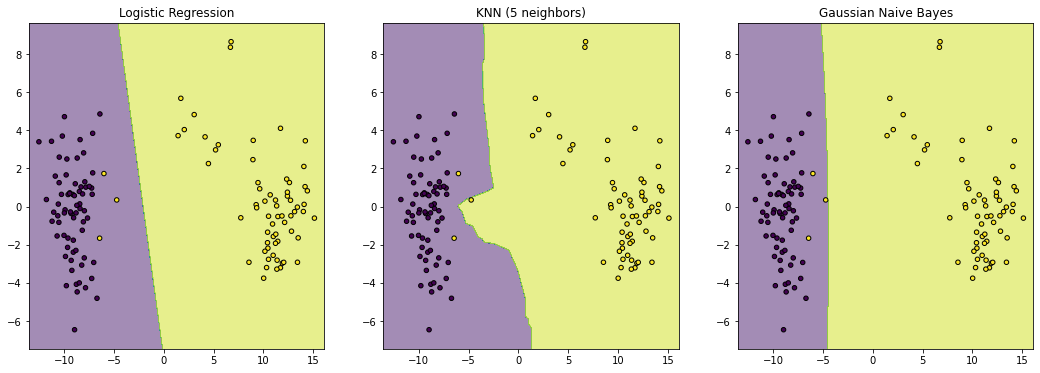

             Classifier  Training Accuracy  Testing Accuracy   Condition
0   Logistic Regression           1.000000          0.941176  Before PCA
1     KNN (5 neighbors)           0.977941          0.970588  Before PCA
2  Gaussian Naive Bayes           0.977941          0.970588  Before PCA
3   Logistic Regression           0.977941          0.970588   After PCA
4     KNN (5 neighbors)           0.985294          0.970588   After PCA
5  Gaussian Naive Bayes           0.977941          0.970588   After PCA


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

# Load data
data = pd.read_csv('marriage.csv', header=None)
data.rename(columns={54: 'y'}, inplace=True)

# Split data into features and target
X = data.iloc[:, :54]
y = data.iloc[:, 54].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4264)

# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver='liblinear'),
    "KNN (5 neighbors)": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naive Bayes": GaussianNB(var_smoothing=0.001)
}

# Function to train classifiers and record accuracies
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    return train_acc, test_acc

# Train and evaluate classifiers before PCA
results = []
for name, clf in classifiers.items():
    train_acc, test_acc = train_and_evaluate(clf, X_train, X_test, y_train, y_test)
    results.append([name, train_acc, test_acc, 'Before PCA'])

# PCA transformation
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate classifiers after PCA
for name, clf in classifiers.items():
    train_acc, test_acc = train_and_evaluate(clf, X_train_pca, X_test_pca, y_train, y_test)
    results.append([name, train_acc, test_acc, 'After PCA'])

# Plot decision boundaries
def plot_decision_boundary(X, y, classifier, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title(title)

# Create a plot for each classifier
plt.figure(figsize=(18, 6))
for i, (name, clf) in enumerate(classifiers.items()):
    plt.subplot(1, 3, i + 1)
    plot_decision_boundary(X_train_pca, y_train, clf, name)

plt.show()

# Print results in a DataFrame
results_df = pd.DataFrame(results, columns=['Classifier', 'Training Accuracy', 'Testing Accuracy', 'Condition'])
print(results_df)
